### Explore data and plot

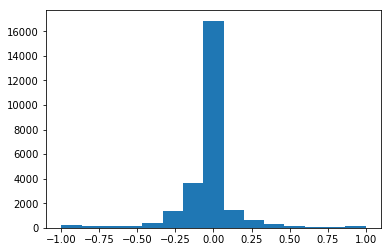

In [1]:
import csv
import cv2
import numpy as np

angle = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if (line[3] != 'steering'):
            angle.append(float(line[3]))
        
with open('data_recovering/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if (line[3] != 'steering'):
            angle.append(float(line[3]))
            import matplotlib.pyplot as plt

plt.hist(angle, bins=15)
plt.show()

### Remove some angles and plot

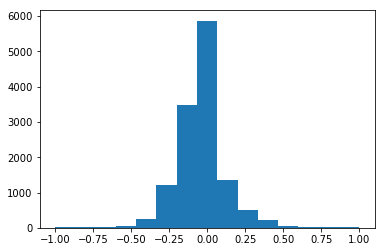

In [2]:
angle = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if (line[3] != 'steering') and ((float(line[3]) == 0.0) and (np.random.rand(1)[0] > 0.90) or (float(line[3]) != 0.0)):
            angle.append(float(line[3]))
        
with open('data_recovering/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if (line[3] != 'steering') and ((float(line[3]) > 1.0) or (float(line[3]) < -1.0)):
            angle.append(float(line[3]))
            import matplotlib.pyplot as plt

plt.hist(angle, bins=15)
plt.show()

In [1]:
import csv
import cv2
import numpy as np

images = []
measurements = []  
correction = 0.2
corrections = [0, correction, -correction]   
print('start processing data')

print('1st data, normal lap')
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
           
for i in range(1,len(lines)):
    # drop most of 0 angle, so model will not be train on a lot of 0
    if ((float(lines[i][3]) == 0.0) and (np.random.rand(1)[0] > 0.90) or (float(lines[i][3]) != 0.0)):
        for j in range(3):
            source_path = lines[i][j]
            filename = source_path.split('/')[-1]
            current_path = 'data/IMG/' + filename
            image = cv2.imread(current_path)
            measurement = float(lines[i][3]) + corrections[j]
            images.append(image)
            measurements.append(measurement)
            image_flipped = np.fliplr(image)
            measurement_flipped = -measurement
            images.append(image_flipped)
            measurements.append(measurement_flipped)
            
print('2nd data, prevent off road')
lines = []
with open('data_off_road_1/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
           
for i in range(1,len(lines)):
    # drop most of 0 angle, so model will not be train on a lot of 0
    if ((float(lines[i][3]) == 0.0) and (np.random.rand(1)[0] > 0.90) or (float(lines[i][3]) != 0.0)):
        for j in range(3):
            source_path = lines[i][j]
            filename = source_path.split('/')[-1]
            current_path = 'data_off_road_1/IMG/' + filename
            image = cv2.imread(current_path)
            measurement = float(lines[i][3]) + corrections[j]
            images.append(image)
            measurements.append(measurement)
            image_flipped = np.fliplr(image)
            measurement_flipped = -measurement
            images.append(image_flipped)
            measurements.append(measurement_flipped)
            
print('3th data, prevent off road')
lines = []
with open('data_off_road_2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
           
for i in range(1,len(lines)):
    # drop most of 0 angle, so model will not be train on a lot of 0
    if ((float(lines[i][3]) == 0.0) and (np.random.rand(1)[0] > 0.90) or (float(lines[i][3]) != 0.0)):
        for j in range(3):
            source_path = lines[i][j]
            filename = source_path.split('/')[-1]
            current_path = 'data_off_road_2/IMG/' + filename
            image = cv2.imread(current_path)
            measurement = float(lines[i][3]) + corrections[j]
            images.append(image)
            measurements.append(measurement)
            image_flipped = np.fliplr(image)
            measurement_flipped = -measurement
            images.append(image_flipped)
            measurements.append(measurement_flipped)
        
print('4th data, recovering')
lines = []
with open('data_recovering/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
for i in range(1,len(lines)):
    # remove angle between -1 to 1, prevent influence to center lane data set
    if ((float(lines[i][3]) > 1.0) or (float(lines[i][3]) < -1.0)):
        for j in range(3):
            source_path = lines[i][j]
            filename = source_path.split('/')[-1]
            current_path = 'data_recovering/IMG/' + filename
            image = cv2.imread(current_path)
            measurement = float(lines[i][3]) + corrections[j]
            images.append(image)
            measurements.append(measurement)
            image_flipped = np.fliplr(image)
            measurement_flipped = -measurement
            images.append(image_flipped)
            measurements.append(measurement_flipped)
        
print('done processing data')
    
print('start trainning')
X_train = np.array(images)
y_train = np.array(measurements)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
# Normalize
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))

# Crop, input shape (160, 320, 3), output shape (60, 320, 3)
model.add(Cropping2D(cropping=((70,26),(0,0))))

# Convolution layer 1, input shape (64, 320, 3), filtter shape (3, 3, 8), output shape (64, 320, 8)
model.add(Convolution2D(8, 3, strides=1, activation="relu", padding="same"))

# MaxPooling, input shape (64, 320, 8), output shape (32, 160, 8)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 2, input shape (32, 160, 8), filtter shape (3, 3, 16), output shape (32, 160, 16)
model.add(Convolution2D(16, 3, strides=1, activation="relu", padding="same"))

# MaxPooling, input shape (32, 160, 16), output shape (16, 80, 16)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 3, input shape (16, 80, 16), filtter shape (3, 3, 32), output shape (16, 80, 32)
model.add(Convolution2D(32, 3, strides=1, activation="relu", padding="same"))

# Convolution layer 4, input shape (16, 80, 32), filtter shape (3, 3, 32), output shape (16, 80, 32)
model.add(Convolution2D(32, 3, strides=1, activation="relu", padding="same"))

# MaxPooling, input shape (16, 80, 32), output shape (8, 40, 32)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 5, input shape (8, 40, 32), filtter shape (3, 3, 64), output shape (8, 40, 64)
model.add(Convolution2D(64, 3, strides=1, activation="relu", padding="same"))

# Convolution layer 6, input shape (8, 40, 64), filtter shape (3, 3, 64), output shape (8, 40, 64)
model.add(Convolution2D(64, 3, strides=1, activation="relu", padding="same"))

# MaxPooling, input shape (8, 40, 64), output shape (4, 20, 64)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 7, input shape (4, 20, 64), filtter shape (3, 3, 64), output shape (4, 20, 64)
model.add(Convolution2D(64, 3, strides=1, activation="relu", padding="same"))

# Convolution layer 8, input shape (4, 20, 64), filtter shape (3, 3, 64), output shape (4, 20, 64)
model.add(Convolution2D(64, 3, strides=1, activation="relu", padding="same"))

# MaxPooling, input shape (4, 20, 64), output shape (2, 10, 64)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten, input shape (2, 10, 64), output shape (1280)
model.add(Flatten())

# Fully connected layer 9, input shape (1280), output shape (1280)
model.add(Dense(1280))

# Dropout rate 50%
model.add(Dropout(0.5))

# Fully connected layer 10, input shape (1280), output shape (640)
model.add(Dense(640))

# Dropout rate 50%
model.add(Dropout(0.5))

# Fully connected layer 11, input shape (640), output shape (1)
model.add(Dense(1))

# Compute loss by mean squared error, Optimize by adam
model.compile(loss='mse', optimizer='adam')

# Split training/validation by 80/20, shuffle data, number of epoch is 10
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=10)

print('done trainning')

print('save model')
model.save('model.h5')

start processing data
1st data, normal lap
2nd data, prevent off road
3th data, prevent off road
4th data, recovering
done processing data
start trainning


Using TensorFlow backend.
/home/titee/anaconda3/lib/python3.6/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)
/home/titee/anaconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 67545 samples, validate on 16887 samples
Epoch 1/10
67545/67545 [==============================] - 138s - loss: 0.0280 - val_loss: 0.0286
Epoch 2/10
67545/67545 [==============================] - 147s - loss: 0.0235 - val_loss: 0.0262
Epoch 3/10
67545/67545 [==============================] - 163s - loss: 0.0223 - val_loss: 0.0274
Epoch 4/10
67545/67545 [==============================] - 168s - loss: 0.0213 - val_loss: 0.0276
Epoch 5/10
67545/67545 [==============================] - 158s - loss: 0.0202 - val_loss: 0.0275
Epoch 6/10
67545/67545 [==============================] - 139s - loss: 0.0197 - val_loss: 0.0245
Epoch 7/10
67545/67545 [==============================] - 132s - loss: 0.0191 - val_loss: 0.0257
Epoch 8/10
67545/67545 [==============================] - 133s - loss: 0.0187 - val_loss: 0.0230
Epoch 9/10
67545/67545 [==============================] - 133s - loss: 0.0183 - val_loss: 0.0246
Epoch 10/10
67545/67545 [==============================] - 134s - loss: 0.017